In [ ]:
pip install dgl-cu101

     |████████████████████████████████| 25.0MB 1.3MB/s 


In [ ]:
# Contruct a two-layer GNN model
import dgl.nn as dglnn
import torch.nn as nn
import torch.nn.functional as F
import dgl
import torch
import dgl.function as fn
import numpy as np
import seaborn as sns

DGL backend not selected or invalid.  Assuming PyTorch for now.
Using backend: pytorch


Setting the default backend to "pytorch". You can change it in the ~/.dgl/config.json file or export the DGLBACKEND environment variable.  Valid options are: pytorch, mxnet, tensorflow (all lowercase)


In [ ]:
class SAGE(nn.Module):
    def __init__(self, in_feats, hid_feats, out_feats):
        super().__init__()
        self.conv1 = dglnn.SAGEConv(
            in_feats=in_feats, out_feats=hid_feats, aggregator_type='mean')
        self.conv2 = dglnn.SAGEConv(
            in_feats=hid_feats, out_feats=out_feats, aggregator_type='mean')

    def forward(self, graph, inputs):
        # inputs are features of nodes
        h = self.conv1(graph, inputs)
        h = F.relu(h)
        h = self.conv2(graph, h)
        return h

In [ ]:
dataset = dgl.data.CiteseerGraphDataset()
graph = dataset[0]

Loading from cache failed, re-processing.


C:\Users\ME\Anaconda3\envs\tf-gpu5\lib\site-packages\dgl\data\citation_graph.py:258: RuntimeWarning: divide by zero encountered in power
  r_inv = np.power(rowsum, -1).flatten()


Finished data loading and preprocessing.
  NumNodes: 3327
  NumEdges: 9228
  NumFeats: 3703
  NumClasses: 6
  NumTrainingSamples: 120
  NumValidationSamples: 500
  NumTestSamples: 1000
Done saving data into cached files.


In [ ]:
dir(graph)

['__class__',
 '__contains__',
 '__copy__',
 '__delattr__',
 '__dict__',
 '__dir__',
 '__doc__',
 '__eq__',
 '__format__',
 '__ge__',
 '__getattribute__',
 '__getitem__',
 '__gt__',
 '__hash__',
 '__init__',
 '__init_subclass__',
 '__le__',
 '__len__',
 '__lt__',
 '__module__',
 '__ne__',
 '__new__',
 '__reduce__',
 '__reduce_ex__',
 '__repr__',
 '__setattr__',
 '__setstate__',
 '__sizeof__',
 '__str__',
 '__subclasshook__',
 '__weakref__',
 '_batch_num_edges',
 '_batch_num_nodes',
 '_canonical_etypes',
 '_dsttypes_invmap',
 '_edge_frames',
 '_etype2canonical',
 '_etypes',
 '_etypes_invmap',
 '_find_etypes',
 '_get_e_repr',
 '_get_n_repr',
 '_graph',
 '_idtype_str',
 '_init',
 '_is_unibipartite',
 '_node_frames',
 '_ntypes',
 '_pop_e_repr',
 '_pop_n_repr',
 '_reset_cached_info',
 '_set_e_repr',
 '_set_n_repr',
 '_srctypes_invmap',
 'add_edge',
 'add_edges',
 'add_nodes',
 'add_self_loop',
 'adj',
 'adjacency_matrix',
 'adjacency_matrix_scipy',
 'all_edges',
 'apply_edges',
 'apply_node

In [ ]:
graph.number_of_edges()

9228

In [ ]:
graph.number_of_nodes()

3327

In [ ]:
import networkx as nx
import matplotlib.pyplot as plt
# Since the actual graph is undirected, we convert it for visualization
# purpose.
nx_G = graph.to_networkx().to_undirected()

In [ ]:
dir(nx_G)

['__class__',
 '__contains__',
 '__delattr__',
 '__dict__',
 '__dir__',
 '__doc__',
 '__eq__',
 '__format__',
 '__ge__',
 '__getattribute__',
 '__getitem__',
 '__gt__',
 '__hash__',
 '__init__',
 '__init_subclass__',
 '__iter__',
 '__le__',
 '__len__',
 '__lt__',
 '__module__',
 '__ne__',
 '__new__',
 '__reduce__',
 '__reduce_ex__',
 '__repr__',
 '__setattr__',
 '__sizeof__',
 '__str__',
 '__subclasshook__',
 '__weakref__',
 '_adj',
 '_node',
 'add_edge',
 'add_edges_from',
 'add_node',
 'add_nodes_from',
 'add_weighted_edges_from',
 'adj',
 'adjacency',
 'adjlist_inner_dict_factory',
 'adjlist_outer_dict_factory',
 'clear',
 'copy',
 'degree',
 'edge_attr_dict_factory',
 'edge_key_dict_factory',
 'edge_subgraph',
 'edges',
 'get_edge_data',
 'graph',
 'graph_attr_dict_factory',
 'has_edge',
 'has_node',
 'is_directed',
 'is_multigraph',
 'name',
 'nbunch_iter',
 'neighbors',
 'new_edge_key',
 'node_attr_dict_factory',
 'node_dict_factory',
 'nodes',
 'number_of_edges',
 'number_of_nod

In [ ]:
# Kamada-Kawaii layout usually looks pretty for arbitrary graphs
pos = nx.kamada_kawai_layout(nx_G)
f, ax = plt.subplots(figsize=(15,15))
nx.draw(nx_G, pos, ax=ax, with_labels=True, node_color=[[.7, .7, .7]], node_size=20, font_size=8)

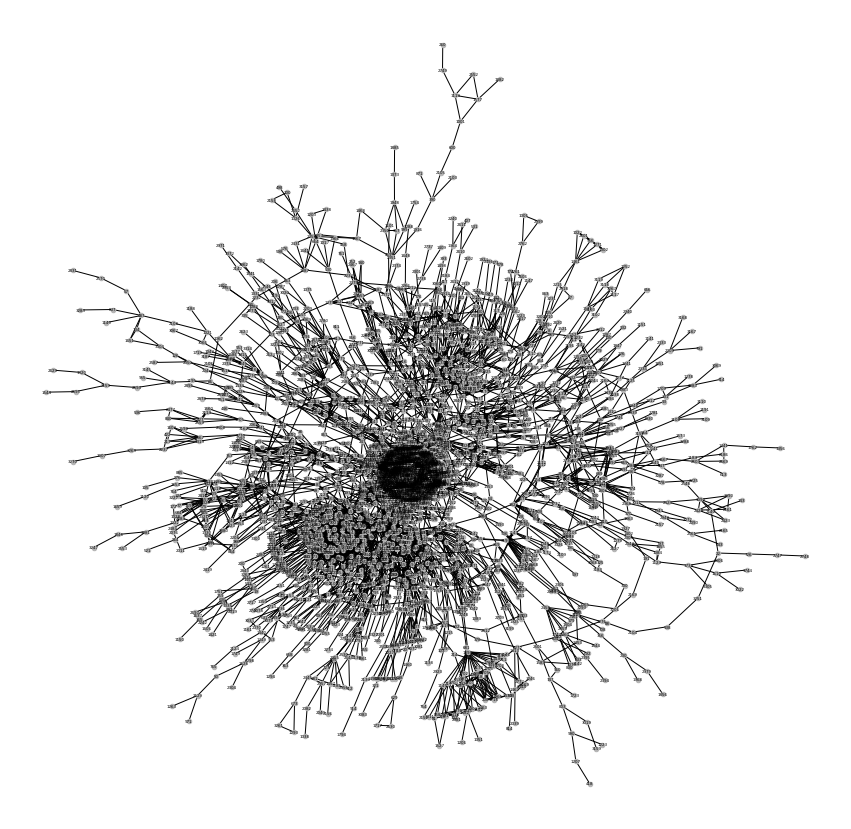

In [ ]:
f, ax = plt.subplots(figsize=(15,15))
nx.draw(nx_G, pos, ax=ax, with_labels=True, node_color=[[.7, .7, .7]], node_size=20, font_size=4)

In [ ]:
node_features = graph.ndata['feat']
node_labels = graph.ndata['label']
train_mask = graph.ndata['train_mask']
valid_mask = graph.ndata['val_mask']
test_mask = graph.ndata['test_mask']
n_features = node_features.shape[1]
n_labels = int(node_labels.max().item() + 1)

In [ ]:
# def evaluate(model, graph, features, labels, mask):
#     model.eval()
#     with torch.no_grad():
#         logits = model(graph, features)
#         logits = logits[mask]
#         labels = labels[mask]
#         _, indices = torch.max(logits, dim=1)
#         correct = torch.sum(indices == labels)
#         return correct.item() * 1.0 / len(labels)

In [ ]:
# model = SAGE(in_feats=n_features, hid_feats=100, out_feats=n_labels)
# opt = torch.optim.Adam(model.parameters())

# for epoch in range(100):
#     model.train()
#     # forward propagation by using all nodes
#     logits = model(graph, node_features)
#     # compute loss
#     loss = F.cross_entropy(logits[train_mask], node_labels[train_mask])
#     # compute validation accuracy
#     acc = evaluate(model, graph, node_features, node_labels, valid_mask)
#     # backward propagation
#     opt.zero_grad()
#     loss.backward()
#     opt.step()
#     if epoch%10 == 0:
#         print(epoch, acc, loss.item())


0 0.212 1.7908122539520264
10 0.59 1.629941701889038
20 0.662 1.4184155464172363
30 0.67 1.1883320808410645
40 0.674 0.9592266082763672
50 0.692 0.7470731139183044
60 0.692 0.5648910403251648
70 0.686 0.41942882537841797
80 0.686 0.31010672450065613
90 0.682 0.23126564919948578


In [ ]:
# node_features = graph.ndata['feat']
# edge_label = graph.edata['label']
# train_mask = graph.edata['train_mask']
# model = Model(graph.ndata['feat'].shape[1], 2*graph.ndata['feat'].shape[1], 100)
# opt = torch.optim.Adam(model.parameters())
# for epoch in range(10):
#     pred = model(graph, node_features)
#     loss = ((pred[train_mask] - edge_label[train_mask]) ** 2).mean()
#     opt.zero_grad()
#     loss.backward()
#     opt.step()
#     print(loss.item())

0.9661599397659302
1.7240841388702393
0.9626089334487915
1.0407134294509888
1.3479441404342651
1.1545902490615845
1.0071256160736084
0.9688408970832825
0.962687611579895
0.9624067544937134


In [ ]:
graph.edata

{}

In [ ]:
graph.ndata['feat'].shape

torch.Size([3327, 3703])

In [ ]:
graph.ndata['feat']

tensor([[0., 0., 0.,  ..., 0., 0., 0.],
        [0., 0., 0.,  ..., 0., 0., 0.],
        [0., 0., 0.,  ..., 0., 0., 0.],
        ...,
        [0., 0., 0.,  ..., 0., 0., 0.],
        [0., 0., 0.,  ..., 0., 0., 0.],
        [0., 0., 0.,  ..., 0., 0., 0.]])

In [ ]:
import numpy as np
np.max(graph.ndata['feat'].numpy())
np.min(graph.ndata['feat'].numpy())

0.0

Link Prediction

In [ ]:
# graph.edata['feat'] = torch.randn(graph.number_of_edges(), 10)
# graph.edata['label'] = torch.randn(graph.number_of_edges())
# graph.edata['train_mask'] = torch.zeros(graph.number_of_edges(), dtype=torch.bool).bernoulli(0.6)

In [ ]:
class DotProductPredictor(nn.Module):
    def forward(self, graph, h):
        # h contains the node representations computed from the GNN defined
        # in the node classification section (Section 5.1).
        with graph.local_scope():
            graph.ndata['h'] = h
            graph.apply_edges(fn.u_dot_v('h', 'h', 'score'))
            return graph.edata['score']

In [ ]:
def construct_negative_graph(graph, k):
    src, dst = graph.edges()

    neg_src = src.repeat_interleave(k)
    neg_dst = torch.randint(0, graph.number_of_nodes(), (len(src) * k,))
    return dgl.graph((neg_src, neg_dst), num_nodes=graph.number_of_nodes())

In [ ]:
class Model(nn.Module):
    def __init__(self, in_features, hidden_features, out_features):
        super().__init__()
        self.sage = SAGE(in_features, hidden_features, out_features)
        self.pred = DotProductPredictor()
    def forward(self, g, neg_g, x):
        h = self.sage(g, x)
        return self.pred(g, h), self.pred(neg_g, h)

In [ ]:
def compute_loss(pos_score, neg_score):
    # Margin loss
    n_edges = pos_score.shape[0]
    return (1 - neg_score.view(n_edges, -1) + pos_score.unsqueeze(1)).clamp(min=0).mean()

In [ ]:
node_features = graph.ndata['feat']
n_features = node_features.shape[1]
k = 5
model = Model(n_features, 100, 100)
opt = torch.optim.Adam(model.parameters())

In [ ]:
for epoch in range(100):
    negative_graph = construct_negative_graph(graph, k)
    pos_score, neg_score = model(graph, negative_graph, node_features)
    loss = compute_loss(pos_score, neg_score)
    opt.zero_grad()
    loss.backward()
    opt.step()
    if epoch%5 == 0:
        print(loss.item())

0.9327231645584106
0.8925142884254456
0.8535833954811096
0.8241052031517029
0.8070580363273621
0.7938827872276306
0.7811102867126465
0.7729514837265015
0.7669843435287476
0.7634453773498535
0.7558466792106628
0.750066339969635
0.7405670881271362
0.7260099649429321
0.7068167924880981
0.6726475358009338
0.6278881430625916
0.5792577862739563
0.5379955768585205
0.49939826130867004


In [ ]:
node_embeddings = model.sage(graph, node_features)

In [ ]:
node_embeddings.shape

torch.Size([3327, 100])

In [ ]:
import matplotlib.pyplot as plt
import matplotlib.cm as cm
from sklearn.manifold import TSNE

In [ ]:
Embedding_TSNE = TSNE(2, perplexity = 10, learning_rate=10, verbose=1, n_iter=2000, random_state=2020)
Y = Embedding_TSNE.fit_transform(node_embeddings.detach().numpy())

[t-SNE] Computing 31 nearest neighbors...
[t-SNE] Indexed 3327 samples in 0.145s...
[t-SNE] Computed neighbors for 3327 samples in 2.802s...
[t-SNE] Computed conditional probabilities for sample 1000 / 3327
[t-SNE] Computed conditional probabilities for sample 2000 / 3327
[t-SNE] Computed conditional probabilities for sample 3000 / 3327
[t-SNE] Computed conditional probabilities for sample 3327 / 3327
[t-SNE] Mean sigma: 0.089674
[t-SNE] KL divergence after 250 iterations with early exaggeration: 79.154106
[t-SNE] KL divergence after 2000 iterations: 1.665534


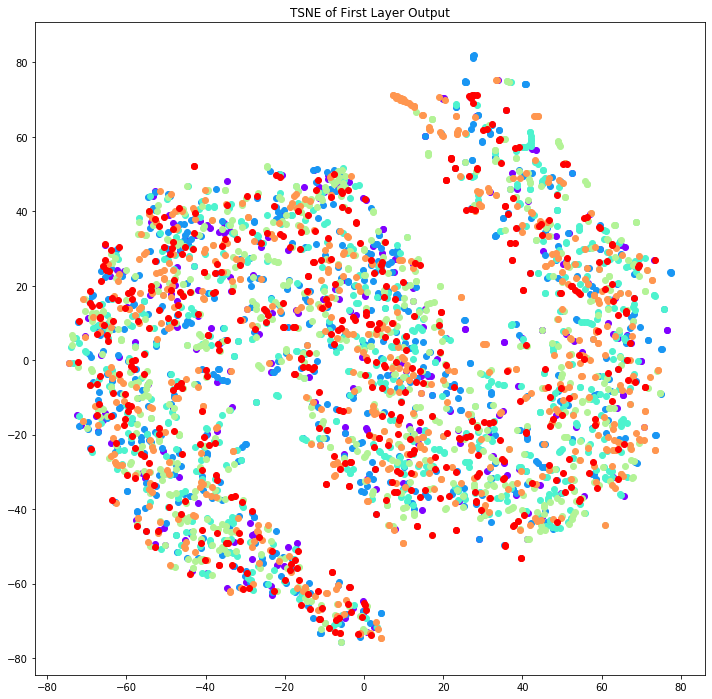

In [ ]:
fig = plt.figure(figsize=(12, 12))
colors = cm.rainbow(np.linspace(0, 1, max(node_labels.numpy())+1)) 
ax = fig.add_subplot()
for i in range(0,max(node_labels.numpy())+1):
    label_index = (node_labels.numpy() == i)
    #color_indx = int(trainset.labels[i].detach().numpy());
    ax.scatter(Y[label_index, 0], Y[label_index, 1],color=colors[i])
#handles, labels = ax.get_legend_handles_labels()
#plt.legend(['cycle_graph','star_graph','wheel_graph','lollipop_graph','hypercube_graph','grid_graph','complete_graph','circular_ladder_graph'], loc='best')
plt.title('TSNE of First Layer Output')
plt.show()

In [ ]:
node_labels.numpy()

array([3, 1, 5, ..., 3, 1, 5], dtype=int64)

In [ ]:
dstnodes = graph.dstnodes()
srcnodes = graph.srcnodes()

In [ ]:
dstnodes

tensor([   0,    1,    2,  ..., 3324, 3325, 3326])

In [ ]:
srcnodes

tensor([   0,    1,    2,  ..., 3324, 3325, 3326])

In [ ]:
dstnodes.shape

torch.Size([3327])

In [ ]:
srcnodes.shape

torch.Size([3327])

In [ ]:
graph.edges()

(tensor([   0,    1,    1,  ..., 3324, 3325, 3326]),
 tensor([ 628,  158, 2919,  ..., 2820, 1643,   33]))

In [ ]:
edges = graph.edges()
edges[0].shape

torch.Size([9228])

In [ ]:
pos_score

tensor([[1.6344],
        [1.3258],
        [1.2850],
        ...,
        [1.2952],
        [1.6550],
        [1.5728]], grad_fn=<GSDDMMBackward>)

In [ ]:
pos_score.shape

torch.Size([9228, 1])

In [ ]:
neg_score

tensor([[1.6326],
        [1.5990],
        [1.6867],
        ...,
        [1.4907],
        [1.5646],
        [1.6413]], grad_fn=<GSDDMMBackward>)

In [ ]:
neg_score.shape

torch.Size([46140, 1])

In [ ]:
graph.srcnodes

In [ ]:
graph.ndata['feat'].shape[0]

3327

In [ ]:
negative_graph.edges()

(tensor([   0,    0,    0,  ..., 3326, 3326, 3326]),
 tensor([1368, 1039,  837,  ..., 3292, 1496, 3240]))

In [ ]:
negative_graph.edges()[0].shape

torch.Size([46140])

In [ ]:
n_edges = pos_score.shape[0]

In [ ]:
n_edges

9228

In [ ]:
neg_score.view(n_edges, -1)

tensor([[1.6326, 1.5990, 1.6867, 1.4647, 1.4945],
        [1.3118, 1.3027, 1.4234, 1.4368, 1.2246],
        [1.4027, 1.2042, 1.4543, 1.3567, 1.4492],
        ...,
        [1.4659, 1.5005, 1.2479, 1.4709, 1.4707],
        [1.5448, 1.3810, 1.5450, 1.5650, 1.6075],
        [1.4986, 1.6257, 1.4907, 1.5646, 1.6413]], grad_fn=<ViewBackward>)

In [ ]:
neg_score.view(n_edges, -1).shape

torch.Size([9228, 5])

In [ ]:
pos_score.unsqueeze(1)

tensor([[[1.6344]],

        [[1.3258]],

        [[1.2850]],

        ...,

        [[1.2952]],

        [[1.6550]],

        [[1.5728]]], grad_fn=<UnsqueezeBackward0>)

In [ ]:
graph.ndata['label'].numpy()

array([3, 1, 5, ..., 3, 1, 5], dtype=int64)

In [ ]:
np.max(graph.ndata['label'].numpy())

5

In [ ]:
np.min(graph.ndata['label'].numpy())

NameError: name 'np' is not defined

In [ ]:
def plot(g, attention, ax, nodes_to_plot=None, nodes_labels=None,
         edges_to_plot=None, nodes_pos=None, nodes_colors=None,
         edge_colormap=plt.cm.Reds):
   
    if nodes_to_plot is None:
        nodes_to_plot = sorted(g.nodes())
    if edges_to_plot is None:
        assert isinstance(g, nx.DiGraph), 'Expected g to be an networkx.DiGraph' \
                                          'object, got {}.'.format(type(g))
        edges_to_plot = sorted(g.edges())
    nx.draw_networkx_edges(g, nodes_pos, edgelist=edges_to_plot,
                           edge_color=attention, edge_cmap=edge_colormap,
                           width=1, alpha=0.5, ax=ax, edge_vmin=0,
                           edge_vmax=1)

    if nodes_colors is None:
        nodes_colors = sns.color_palette("deep", max(nodes_labels) + 1)

    nx.draw_networkx_nodes(g, nodes_pos, nodelist=nodes_to_plot, ax=ax, node_size=10,
                           node_color=[nodes_colors[nodes_labels[v - 1]] for v in nodes_to_plot],
                           with_labels=False, alpha=0.9)

In [ ]:
(pos_score.detach().numpy()-1).reshape(pos_score.shape[0],)

array([0.63444865, 0.32576537, 0.28496993, ..., 0.295246  , 0.65495217,
       0.57283115], dtype=float32)

In [ ]:
np.random.ranf(dg.number_of_edges()).shape

(9228,)

(array([1.600e+01, 2.200e+01, 2.960e+02, 3.132e+03, 4.382e+03, 1.183e+03,
        1.680e+02, 2.100e+01, 3.000e+00, 5.000e+00]),
 array([14.71114 , 15.57945 , 16.44776 , 17.316069, 18.18438 , 19.052689,
        19.920998, 20.789309, 21.657618, 22.525928, 23.394238],
       dtype=float32),
 <a list of 10 Patch objects>)

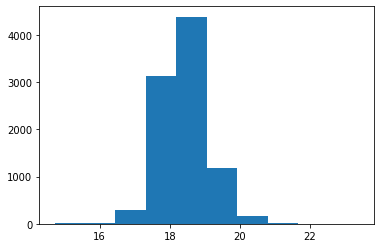

In [ ]:
plt.hist(pos_score.detach().numpy())

(array([2.5700e+02, 2.8263e+04, 1.3871e+04, 2.6630e+03, 7.7100e+02,
        2.1800e+02, 6.2000e+01, 2.4000e+01, 8.0000e+00, 3.0000e+00]),
 array([15.286344, 17.420311, 19.554277, 21.688246, 23.822212, 25.956179,
        28.090147, 30.224113, 32.35808 , 34.492046, 36.626015],
       dtype=float32),
 <a list of 10 Patch objects>)

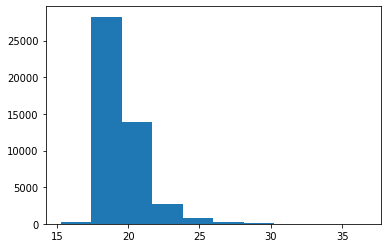

In [ ]:
plt.hist(neg_score.detach().numpy())

In [ ]:
np.max(pos_score.detach().numpy())

1.9063807

In [ ]:
np.min(pos_score.detach().numpy())

0.9394888

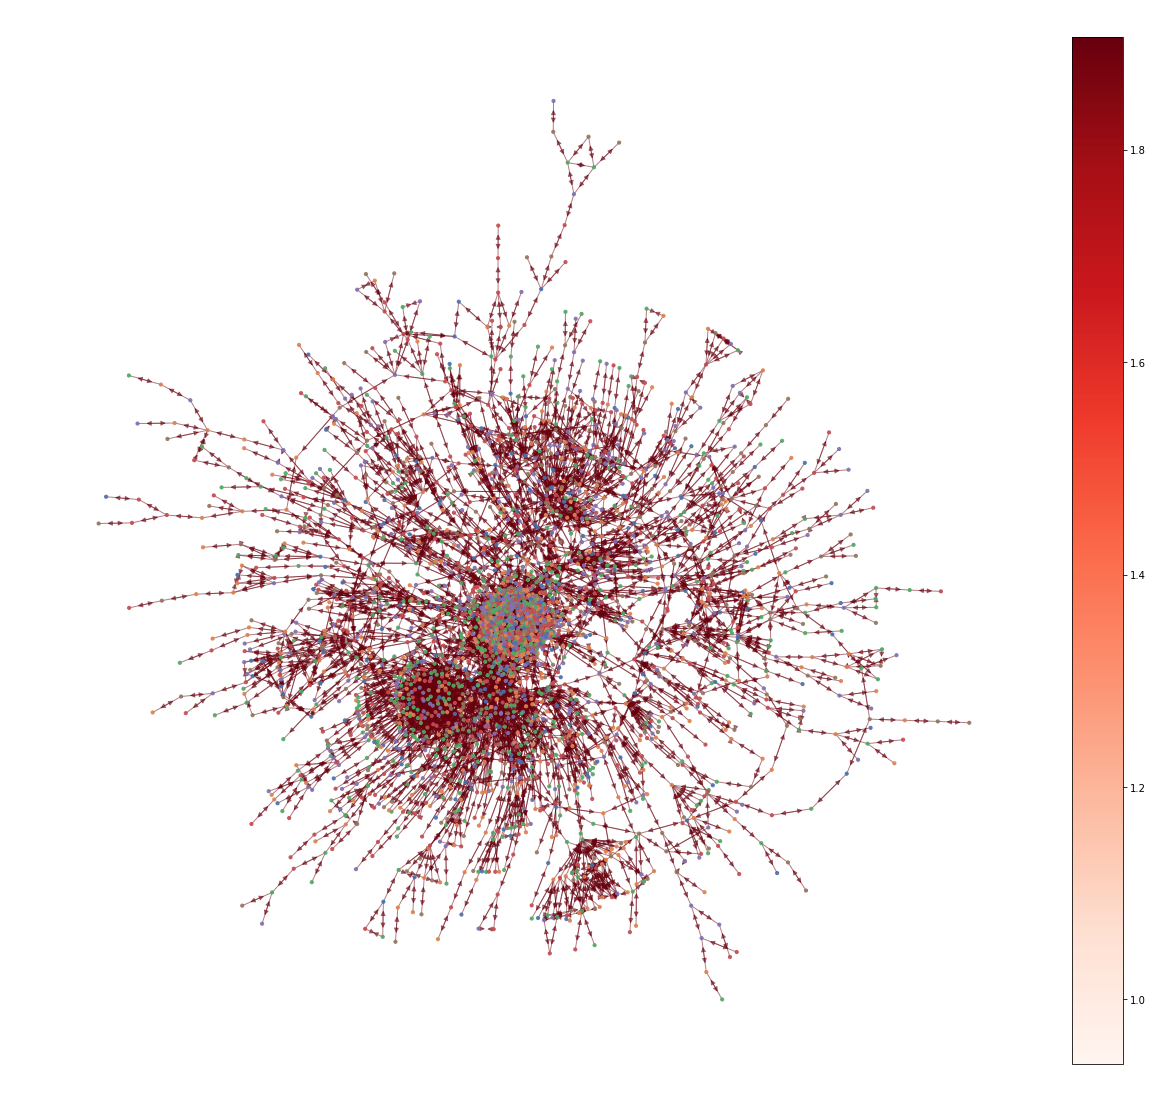

In [ ]:
# attention = np.random.ranf(dg.number_of_edges())
dg = graph.to_networkx().to_directed()
fig, ax = plt.subplots(figsize=(20,20))
# plot(dg, np.random.ranf(dg.number_of_edges()), ax=ax, nodes_pos=nx.circular_layout(dg), nodes_labels=node_labels)
plot(dg, pos_score.detach().numpy().reshape(pos_score.shape[0],), ax=ax, nodes_pos=nx.kamada_kawai_layout(dg), nodes_labels=node_labels)
ax.set_axis_off()
sm = plt.cm.ScalarMappable(cmap=plt.cm.Reds, norm=plt.Normalize(vmin=np.min(pos_score.detach().numpy()), vmax=np.max(pos_score.detach().numpy())))
sm.set_array([])
plt.colorbar(sm, fraction=0.046, pad=0.01)
plt.show()